## In this notebook, we will
1. Import reduction potential data for over 5000 molecules
2. Perform data cleaning operations (correlated feature elimination and p-value hypothesis testing) using customised classes and methods.
3. Split data into 80-20 training and testing tests and save as .csv files for training ML models in the following notebooks

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random 

from Functions import ChemClean
from Functions import Descriptors

In [2]:
import rdkit.Chem as Chem
from rdkit.Chem import rdMolDescriptors 

In [3]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle

import statsmodels.api as sm

## Load data from url

In [13]:
url='https://raw.githubusercontent.com/akashjn/DataScience/main/Data/BTZ_5442mols_smiles_redpot.csv'
data=pd.read_csv(url)
data=data.sample(frac=1)
data.index=range(data.shape[0])
data.head()

,SMILES,ERed
0,CCC(C)N1CCN(CC(C)C)c2cc3nsnc3cc21,1.23
1,CCCC1Oc2cc3nsnc3c(NC)c2OC1C,1.43
2,CCC1COc2c(c(N(CC)CC)c3nsnc3c2C)O1,1.47
3,CCCNc1c(NC)c(NC(C)C)c(C)c2nsnc12,1.44
4,CCCC/C([O-])=[NH+]\c1cccc2nsnc12,1.81


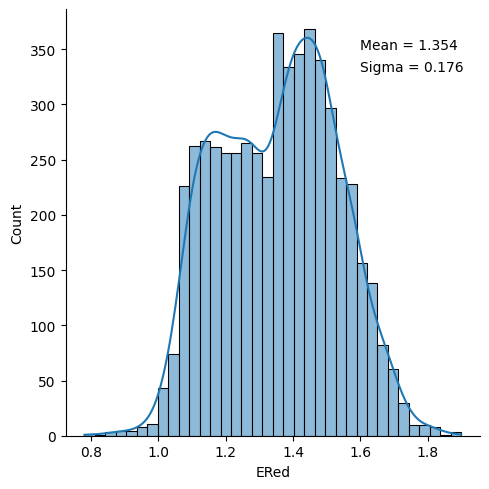

In [14]:
ax=sns.displot(data, x="ERed",kde=True)
plt.text(1.6,350,'Mean = '+str(np.round(np.mean(data['ERed']),3)))
plt.text(1.6,330,'Sigma = '+str(np.round(np.std(data['ERed']),3)))
plt.show()

## Generate descriptors using Descriptors.py

In [16]:
%%time
p=Descriptors.desc(data['SMILES'])
df_rdkit=p.RDkit_descriptors()
print(df_rdkit.shape)
df_rdkit.head()

(5442, 208)
CPU times: user 48.6 s, sys: 172 ms, total: 48.8 s
Wall time: 48.8 s


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,4.417770,0.563884,4.417770,0.563884,0.860405,304.463,280.271,304.172168,114,0,...,0,0,0,0,0,0,0,0,0,0
1,6.076435,0.044995,6.076435,0.044995,0.935434,279.365,262.229,279.104148,102,0,...,0,0,0,0,0,0,0,0,0,0
2,6.225370,0.106720,6.225370,0.106720,0.866171,307.419,286.251,307.135448,114,0,...,0,0,0,0,0,0,0,0,0,0
3,4.461551,0.364694,4.461551,0.364694,0.758063,293.440,270.256,293.167417,110,0,...,0,0,0,0,0,0,0,0,0,0
4,11.581014,0.043843,11.581014,0.043843,0.614246,235.312,222.208,235.077933,84,0,...,0,0,0,0,0,0,0,0,0,0


## Data cleaning operations from ChemClean.py

In [17]:
p=ChemClean.clean(df_rdkit)

In [18]:
p.remove_nan().head()
p.remove_unique().head()
p.remove_columns_low_std(0.1).head()
df_model=p.remove_corr_features(0.7)

# VERIFY HOW FEATURES ARE REMOVED AFTER CHECKING FOR CORRELATION


print(df_model.shape)
df_model.head()

Removing 0 columns with nan, if any
Before: df.shape=(5442, 208)
After: df.shape=(5442, 208) 

removing 84 columns values with a unique value
Before: df.shape=(5442, 208)
After: df.shape=(5442, 124) 

Removed 10 columns with std < 0.1 
Dropped 75 features with correlation coeff. > 0.70
(5442, 39)


,MaxEStateIndex,MinEStateIndex,MolWt,FpDensityMorgan1,BCUT2D_MWLOW,BCUT2D_LOGPLOW,BalabanJ,HallKierAlpha,PEOE_VSA10,PEOE_VSA11,...,VSA_EState2,VSA_EState8,VSA_EState9,NHOHCount,NumAliphaticHeterocycles,fr_ArN,fr_Ndealkylation1,fr_aryl_methyl,fr_bicyclic,fr_unbrch_alkane
0,4.417770,0.563884,304.463,1.095238,10.060638,-2.455566,2.070459,-1.36,11.033401,0.000000,...,5.044259,12.423842,0.000000,0,1,0,0,0,2,0
1,6.076435,0.044995,279.365,1.368421,10.078685,-2.372181,2.095021,-1.56,28.928720,11.499024,...,0.000000,4.198782,1.861665,1,1,0,0,0,2,0
2,6.225370,0.106720,307.419,1.142857,10.079476,-2.310796,2.268283,-1.56,29.431636,11.499024,...,2.267269,10.836800,0.000000,0,1,0,0,1,2,0
3,4.461551,0.364694,293.440,1.100000,10.066091,-2.144483,2.656427,-1.56,11.033401,0.000000,...,0.000000,9.455775,1.947457,3,0,0,0,1,1,0
4,11.581014,0.043843,235.312,1.437500,10.220798,-2.699838,2.289906,-1.49,11.414446,5.516701,...,2.871065,2.067808,0.000000,1,0,0,0,0,1,0


In [19]:
target=data['ERed']
features=df_model.copy()
features.shape
features.head()

,MaxEStateIndex,MinEStateIndex,MolWt,FpDensityMorgan1,BCUT2D_MWLOW,BCUT2D_LOGPLOW,BalabanJ,HallKierAlpha,PEOE_VSA10,PEOE_VSA11,...,VSA_EState2,VSA_EState8,VSA_EState9,NHOHCount,NumAliphaticHeterocycles,fr_ArN,fr_Ndealkylation1,fr_aryl_methyl,fr_bicyclic,fr_unbrch_alkane
0,4.417770,0.563884,304.463,1.095238,10.060638,-2.455566,2.070459,-1.36,11.033401,0.000000,...,5.044259,12.423842,0.000000,0,1,0,0,0,2,0
1,6.076435,0.044995,279.365,1.368421,10.078685,-2.372181,2.095021,-1.56,28.928720,11.499024,...,0.000000,4.198782,1.861665,1,1,0,0,0,2,0
2,6.225370,0.106720,307.419,1.142857,10.079476,-2.310796,2.268283,-1.56,29.431636,11.499024,...,2.267269,10.836800,0.000000,0,1,0,0,1,2,0
3,4.461551,0.364694,293.440,1.100000,10.066091,-2.144483,2.656427,-1.56,11.033401,0.000000,...,0.000000,9.455775,1.947457,3,0,0,0,1,1,0
4,11.581014,0.043843,235.312,1.437500,10.220798,-2.699838,2.289906,-1.49,11.414446,5.516701,...,2.871065,2.067808,0.000000,1,0,0,0,0,1,0


## Feature elimination using p-value test; using Linear Regression

### p-values calculated using ordinary least squares fit

In [20]:
mod = sm.OLS(target,features)
fii = mod.fit()
fii.summary2().tables[1].head()

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
MaxEStateIndex,0.032146,0.002572,12.498263,2.343020e-35,0.027104,0.037188
MinEStateIndex,0.024024,0.008888,2.702920,6.894821e-03,0.006600,0.041449
MolWt,-0.006181,0.000579,-10.669231,2.587961e-26,-0.007317,-0.005045
FpDensityMorgan1,0.040480,0.011253,3.597217,3.245165e-04,0.018419,0.062540
BCUT2D_MWLOW,0.019360,0.011387,1.700172,8.915612e-02,-0.002963,0.041683


### Recursive elimination of all features whose p-value < alpha (=0.02)

In [21]:
alpha=0.02
for a in range(len(features.columns)):
    mod = sm.OLS(target,features)
    fii = mod.fit()
    p_values = fii.summary2().tables[1]['P>|t|']
    cols=[]
    for i in range(len(p_values)):
        if p_values[i]>alpha:
            cols.append(p_values.index[i])
    if len(cols)==0:
        break
    print(len(cols),'descriptors eliminated in iteration',str(a+1))
    features.drop(columns=cols,inplace=True)
    
print('Final model has',features.shape,'desriptors')
features.columns

5 descriptors eliminated in iteration 1
1 descriptors eliminated in iteration 2
1 descriptors eliminated in iteration 3
Final model has (5442, 32) desriptors


Index(['MaxEStateIndex', 'MolWt', 'FpDensityMorgan1', 'BCUT2D_LOGPLOW',
       'BalabanJ', 'HallKierAlpha', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12',
       'PEOE_VSA2', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9',
       'SMR_VSA10', 'SMR_VSA4', 'SMR_VSA5', 'SlogP_VSA3', 'SlogP_VSA4',
       'SlogP_VSA6', 'EState_VSA4', 'EState_VSA6', 'EState_VSA7',
       'EState_VSA8', 'VSA_EState2', 'VSA_EState9', 'NHOHCount',
       'NumAliphaticHeterocycles', 'fr_ArN', 'fr_Ndealkylation1',
       'fr_bicyclic', 'fr_unbrch_alkane'],
      dtype='object')

## Split into 80-20 training and testing sets and save to csv files

In [22]:
features_train,features_test,target_train,target_test=train_test_split(features,target,test_size=0.2,random_state=42)

In [23]:
features_train.index=range(features_train.shape[0])
features_train.to_csv('Data/features_train.csv')
features_test.index=range(features_test.shape[0])
features_test.to_csv('Data/features_test.csv')
target_train.index=range(target_train.shape[0])
target_train.to_csv('Data/target_train.csv')
target_test.index=range(target_test.shape[0])
target_test.to_csv('Data/target_test.csv')

In [24]:
print(target_train.shape,target_test.shape)

(4353,) (1089,)


### Visualise distribution of reduction potentials in the training and testing datasets

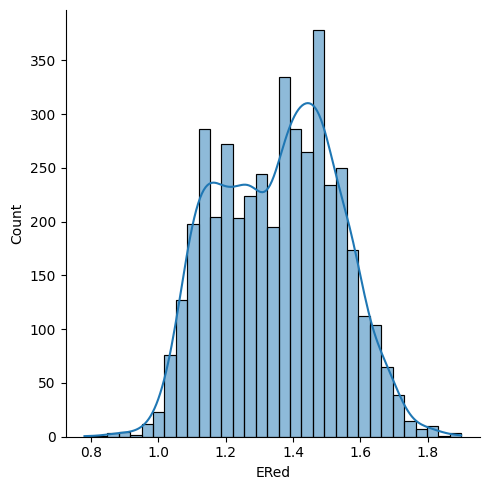

In [10]:
Ered_train=pd.read_csv('Data/target_train.csv')
ax=sns.displot(Ered_train,x='ERed',kde=True)
plt.show()

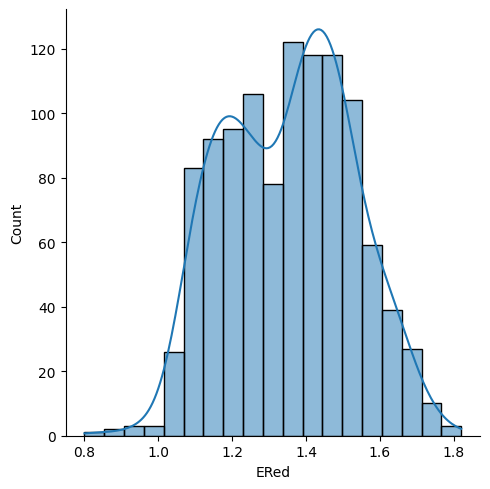

In [13]:
Ered_test=pd.read_csv('Data/target_test.csv')
ax=sns.displot(Ered_test,x='ERed',kde=True)
plt.show()